# Monthly Shipments Forecasting Plan with Prophet (Meta)

## Objectives
- Generate a synthetic monthly time series of historical unit shipments following a k=12 seasonal pattern.
- Fit a Prophet model to forecast monthly shipments and aggregate to annual projections.
- Evaluate forecast performance and compute Forecast Value Added (FVA) vs a baseline (seasonal naïve).

## Deliverables
- Reproducible data generation for monthly shipments with realistic trend/seasonality/noise.
- Prophet forecasts: monthly horizon and annual rollups.
- FVA analysis with clear metrics and visuals.

## Assumptions
- Monthly granularity with `ds` as period start (month start, `MS`).
- Synthetic data length: 5–7 years history (configurable), forecast horizon: 12–24 months (configurable).
- Seasonality is monthly (k=12) plus optional events/promo effects.


## Workflow Overview
1. Configure parameters (history length, horizon, seasonality amplitude, noise).
2. Generate synthetic monthly shipments with k=12 seasonality and trend + noise.
3. Establish baseline: Seasonal Naive (SNaive = last year's month).
4. Fit Prophet; generate monthly forecast and annual rollups.
5. Backtest with rolling-origin CV; compute error metrics.
6. Compute Forecast Value Added (FVA) Prophet vs baseline.
7. Produce plots and summary tables; document assumptions and caveats.


## Configuration and Environment
- Python 3.9+
- Packages: `prophet`, `pandas`, `numpy`, `matplotlib`, `seaborn`, `plotly` (optional), `scikit-learn` (metrics).
- Backend: Prophet with default seasonality; monthly frequency.

We will include a lightweight setup cell to install/import dependencies if needed.


In [1]:
# Setup: install and imports
# If running locally, you may comment out the install line once packages are available
%pip install -q prophet pandas numpy matplotlib seaborn plotly scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set_theme(style="whitegrid")


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Parameters (feel free to adjust)
HISTORY_YEARS = 6
FORECAST_HORIZON_MONTHS = 18
START_DATE = "2018-01-01"
SEASONAL_AMPLITUDE = 0.25  # fraction of base level
NOISE_SD = 0.08            # relative noise (as fraction of level)
GROWTH_RATE = 0.015        # monthly growth in fractional terms
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


## Data Generation Plan (k=12 Seasonality)
- Create a monthly date range from `START_DATE` for `HISTORY_YEARS`.
- Base level of units (e.g., 10,000) with optional trend: multiplicative growth by `GROWTH_RATE` per month.
- Seasonal component: 12-month pattern with configurable month weights summing to 0 (centered) for additive, or around 1 for multiplicative.
- Noise: Gaussian noise scaled by `NOISE_SD` relative to level.
- Output DataFrame with columns `ds` (month start) and `y` (units).
- Visualize the generated series and monthly seasonality profile.


## Baseline (Seasonal Naive) Plan
- Forecast each month as the value from the same month in the previous year.
- Implement function to generate baseline forecasts for both backtesting and future horizon.
- Use as benchmark for FVA.


## Prophet Modeling & Forecasting Plan
- Prepare DataFrame with columns `ds`, `y` (monthly frequency).
- Initialize Prophet with yearly seasonality enabled; disable weekly/daily; consider additive vs multiplicative.
- Fit on training history; create future dataframe for `FORECAST_HORIZON_MONTHS`.
- Generate monthly forecast; select columns: `ds`, `yhat`, `yhat_lower`, `yhat_upper`.
- Aggregate forecast to annual totals for projections; ensure calendar alignment.


## Backtesting & Metrics Plan
- Rolling-origin cross-validation with expanding window; cutoffs every 3 months.
- For each fold, produce Prophet forecast and seasonal naive baseline.
- Metrics: MAE, RMSE, MAPE, sMAPE on monthly level.
- Visual inspection: overlay actual vs forecasts for select windows.


## Forecast Value Added (FVA) Plan
- Define FVA as improvement of advanced method over baseline on error metrics.
- Compute monthly FVA: e.g., `FVA_MAE = 1 - (MAE_prophet / MAE_baseline)`; similar for RMSE, sMAPE, MPE/MDPE.
- Summarize FVA distributions across backtest folds; report mean/median and confidence bands.
- Provide table and chart of FVA by metric.


## Projections & Reporting Plan
- Produce monthly forecast plot with uncertainty bands.
- Aggregate to annual shipments: historical and forecasted totals.
- Create summary tables for monthly and annual projections.
- Add optional interactive visuals with Plotly.


In [3]:
# Helpers: seasonality, data generation, baseline, and metrics
from typing import Tuple

BASE_LEVEL = 10000.0


def generate_monthly_seasonal_factors(amplitude: float = SEASONAL_AMPLITUDE,
                                      phase_shift: float = 0.0,
                                      custom_monthly_shares: np.ndarray | None = None) -> np.ndarray:
	months = np.arange(12)
	if custom_monthly_shares is not None:
		shares = np.asarray(custom_monthly_shares, dtype=float)
		assert shares.shape == (12,), "custom_monthly_shares must have length 12"
		assert np.isfinite(shares).all() and (shares >= 0).all(), "shares must be non-negative"
		assert not np.isclose(shares.sum(), 0), "shares must sum > 0"
		factors = shares / shares.mean()
		return factors
	factors = 1.0 + amplitude * np.sin(2.0 * np.pi * (months - phase_shift) / 12.0)
	factors = factors / factors.mean()
	return factors


def generate_shipments_series(
	start_date: str,
	history_years: int,
	base_level: float = BASE_LEVEL,
	growth_rate: float = GROWTH_RATE,
	seasonal_amplitude: float = SEASONAL_AMPLITUDE,
	noise_sd: float = NOISE_SD,
	custom_monthly_shares: np.ndarray | None = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
	"""Return historical monthly shipments df and monthly seasonal profile df."""
	n_months = history_years * 12
	dates = pd.date_range(start=start_date, periods=n_months, freq="MS")
	trend = (1.0 + growth_rate) ** np.arange(n_months)
	seasonal_factors = generate_monthly_seasonal_factors(
		amplitude=seasonal_amplitude,
		custom_monthly_shares=custom_monthly_shares,
	)
	month_idx = dates.month.values - 1
	level = base_level * trend * seasonal_factors[month_idx]
	noise = np.random.normal(loc=0.0, scale=noise_sd, size=n_months)
	y = np.maximum(0.0, level * (1.0 + noise))
	df = pd.DataFrame({"ds": dates, "y": y})
	seasonal_profile = pd.DataFrame({"month": np.arange(1, 13), "factor": seasonal_factors})
	return df, seasonal_profile


def seasonal_naive_forecast(history_df: pd.DataFrame, future_dates: pd.DatetimeIndex) -> pd.Series:
	hist = history_df.copy()
	hist["month"] = hist["ds"].dt.month
	hist = hist.set_index("ds").sort_index()
	preds: list[float] = []
	for ds in future_dates:
		month = ds.month
		ref_date = ds - pd.DateOffset(years=1)
		if ref_date in hist.index:
			preds.append(float(hist.loc[ref_date, "y"]))
		else:
			month_vals = hist[hist["month"] == month]["y"]
			preds.append(float(month_vals.iloc[-1]) if not month_vals.empty else float(hist["y"].iloc[-1]))
	return pd.Series(preds, index=future_dates, name="yhat_baseline")


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
	y_true = np.asarray(y_true)
	y_pred = np.asarray(y_pred)
	mask = y_true != 0
	if not mask.any():
		return np.nan
	return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
	"""Mean Percentage Error (can be negative; bias-oriented)."""
	y_true = np.asarray(y_true)
	y_pred = np.asarray(y_pred)
	mask = y_true != 0
	if not mask.any():
		return np.nan
	return float(np.mean(((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100.0)


def mdpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
	"""Median Percentage Error (robust to outliers)."""
	y_true = np.asarray(y_true)
	y_pred = np.asarray(y_pred)
	mask = y_true != 0
	if not mask.any():
		return np.nan
	return float(np.median(((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100.0)


def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
	y_true = np.asarray(y_true)
	y_pred = np.asarray(y_pred)
	num = np.abs(y_true - y_pred)
	den = (np.abs(y_true) + np.abs(y_pred))
	mask = den != 0
	if not mask.any():
		return np.nan
	return float(np.mean(2.0 * num[mask] / den[mask]) * 100.0)


,ds,y
0,2018-01-01,10397.371322
1,2018-02-01,11292.445561
2,2018-03-01,13182.138168
3,2018-04-01,14663.579073
4,2018-05-01,12669.692266


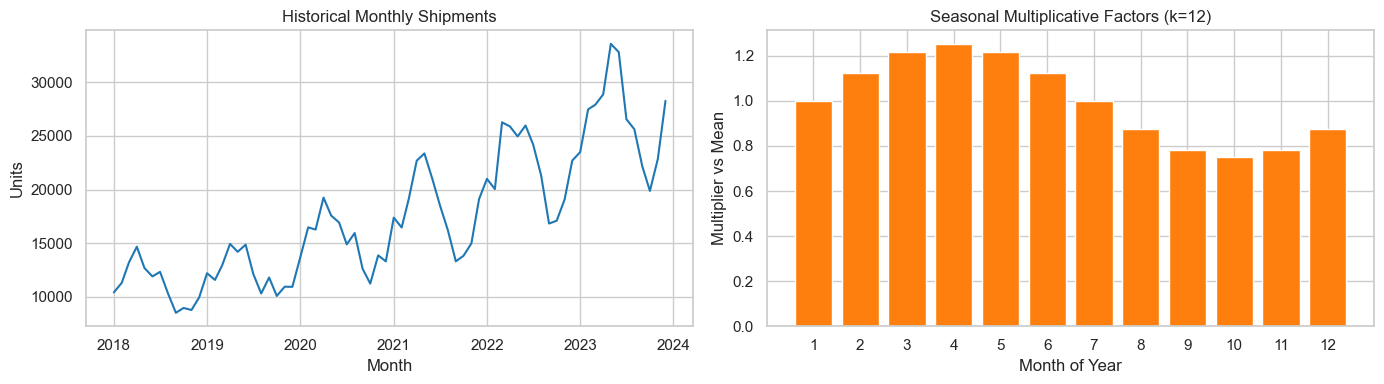

In [4]:
# Generate synthetic history and visualize
hist_df, seasonal_profile = generate_shipments_series(
	start_date=START_DATE,
	history_years=HISTORY_YEARS,
	base_level=BASE_LEVEL,
	growth_rate=GROWTH_RATE,
	seasonal_amplitude=SEASONAL_AMPLITUDE,
	noise_sd=NOISE_SD,
)

display(hist_df.head())

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(hist_df["ds"], hist_df["y"], color="tab:blue")
ax[0].set_title("Historical Monthly Shipments")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Units")

ax[1].bar(seasonal_profile["month"], seasonal_profile["factor"], color="tab:orange")
ax[1].set_xticks(range(1, 13))
ax[1].set_title("Seasonal Multiplicative Factors (k=12)")
ax[1].set_xlabel("Month of Year")
ax[1].set_ylabel("Multiplier vs Mean")
plt.tight_layout()
plt.show()


## Custom Seasonality Overrides
- Apply custom monthly shares where July and August account for 70% of annual volume and the remaining 30% is evenly distributed across the other months.
- Overrides helper functions to accept `custom_monthly_shares` for data generation.


In [5]:
# Rolling-origin backtest: Prophet vs Seasonal Naive + FVA

def rolling_backtest_prophet_vs_baseline(
	df: pd.DataFrame,
	initial_train_years: int = 3,
	horizon_months: int = 12,
	step_months: int = 3,
	seasonality_mode: str = "multiplicative",
) -> pd.DataFrame:
	cutoff = df["ds"].min() + pd.DateOffset(years=initial_train_years)
	cutoffs: list[pd.Timestamp] = []
	while cutoff + pd.DateOffset(months=horizon_months) <= df["ds"].max():
		cutoffs.append(cutoff)
		cutoff += pd.DateOffset(months=step_months)

	records: list[dict] = []
	for c in cutoffs:
		train = df[df["ds"] <= c].copy()
		test = df[(df["ds"] > c) & (df["ds"] <= c + pd.DateOffset(months=horizon_months))].copy()
		if test.empty:
			continue

		m = Prophet(
			weekly_seasonality=False,
			daily_seasonality=False,
			yearly_seasonality=True,
			seasonality_mode=seasonality_mode,
		)
		m.fit(train.rename(columns={"ds": "ds", "y": "y"}))
		future = pd.DataFrame({"ds": test["ds"]})
		fcst = m.predict(future)
		yhat_prophet = fcst["yhat"].to_numpy()

		yhat_baseline = seasonal_naive_forecast(train, test["ds"]).to_numpy()

		y_true = test["y"].to_numpy()
		# Compute RMSE explicitly to avoid squared kwarg compatibility issues
		rmse_prophet = float(np.sqrt(mean_squared_error(y_true, yhat_prophet)))
		rmse_baseline = float(np.sqrt(mean_squared_error(y_true, yhat_baseline)))
		records.append({
			"cutoff": c,
			"MAE_Prophet": mean_absolute_error(y_true, yhat_prophet),
			"RMSE_Prophet": rmse_prophet,
			"sMAPE_Prophet": smape(y_true, yhat_prophet),
			"MPE_Prophet": mpe(y_true, yhat_prophet),
			"MAE_Baseline": mean_absolute_error(y_true, yhat_baseline),
			"RMSE_Baseline": rmse_baseline,
			"sMAPE_Baseline": smape(y_true, yhat_baseline),
			"MPE_Baseline": mpe(y_true, yhat_baseline),
		})

	results = pd.DataFrame(records)
	if not results.empty:
		results["FVA_MAE"] = 1.0 - (results["MAE_Prophet"] / results["MAE_Baseline"])
		results["FVA_RMSE"] = 1.0 - (results["RMSE_Prophet"] / results["RMSE_Baseline"])
		results["FVA_sMAPE"] = 1.0 - (results["sMAPE_Prophet"] / results["sMAPE_Baseline"])
		# For MPE, smaller magnitude is better; use absolute MPE for FVA
		results["FVA_|MPE|"] = 1.0 - (np.abs(results["MPE_Prophet"]) / np.abs(results["MPE_Baseline"]))
	return results

# WARNING: First Prophet fit will download/compile CmdStan; may take several minutes.
BACKTEST_INITIAL_YEARS = 3
BACKTEST_HORIZON_MONTHS = 12
BACKTEST_STEP_MONTHS = 3

# Uncomment to run backtest (can be slow on first run)
# backtest_results = rolling_backtest_prophet_vs_baseline(
# 	hist_df,
# 	initial_train_years=BACKTEST_INITIAL_YEARS,
# 	horizon_months=BACKTEST_HORIZON_MONTHS,
# 	step_months=BACKTEST_STEP_MONTHS,
# 	seasonality_mode="multiplicative",
# )
# display(backtest_results)
# if not backtest_results.empty:
# 	print("Mean metrics across folds:")
# 	display(backtest_results[[
# 		"MAE_Prophet","MAE_Baseline","FVA_MAE",
# 		"RMSE_Prophet","RMSE_Baseline","FVA_RMSE",
# 		"sMAPE_Prophet","sMAPE_Baseline","FVA_sMAPE",
# 	]].mean().to_frame("mean").T)


11:25:28 - cmdstanpy - INFO - Chain [1] start processing


11:25:28 - cmdstanpy - INFO - Chain [1] done processing


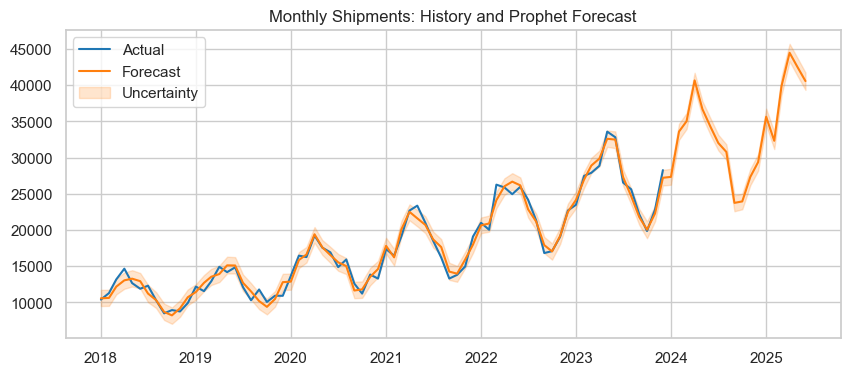

,year,actual,yhat,yhat_lower,yhat_upper
0,2018,132841.719298,NaN,NaN,NaN
1,2019,146762.098994,NaN,NaN,NaN
2,2020,181934.154354,NaN,NaN,NaN
3,2021,215939.618474,NaN,NaN,NaN
4,2022,265339.155113,NaN,NaN,NaN
5,2023,319578.074118,NaN,NaN,NaN
6,2024,NaN,374864.829248,361519.778266,388045.516729
7,2025,NaN,235486.306245,228303.075896,242842.974573


In [6]:
# Full-history Prophet forecast and annual rollups
SEASONALITY_MODE = "multiplicative"

m_full = Prophet(
	weekly_seasonality=False,
	daily_seasonality=False,
	yearly_seasonality=True,
	seasonality_mode=SEASONALITY_MODE,
)
m_full.fit(hist_df)

future = m_full.make_future_dataframe(periods=FORECAST_HORIZON_MONTHS, freq="MS")
fcst = m_full.predict(future)
forecast_df = fcst[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()

# Join with actuals for plotting
joined = pd.merge(forecast_df, hist_df, on="ds", how="left")

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(joined["ds"], joined["y"], label="Actual", color="tab:blue")
ax.plot(joined["ds"], joined["yhat"], label="Forecast", color="tab:orange")
ax.fill_between(joined["ds"], joined["yhat_lower"], joined["yhat_upper"], color="tab:orange", alpha=0.2, label="Uncertainty")
ax.set_title("Monthly Shipments: History and Prophet Forecast")
ax.legend()
plt.show()

# Annual rollups
hist_annual = hist_df.assign(year=hist_df["ds"].dt.year).groupby("year", as_index=False)["y"].sum().rename(columns={"y": "actual"})
fcst_future = forecast_df[forecast_df["ds"] > hist_df["ds"].max()].copy()
fcst_annual = fcst_future.assign(year=fcst_future["ds"].dt.year).groupby("year", as_index=False)[["yhat","yhat_lower","yhat_upper"]].sum()

# Combine historical actuals and forecast totals
annual_combined = pd.merge(hist_annual, fcst_annual, on="year", how="outer")
display(annual_combined.sort_values("year").reset_index(drop=True))


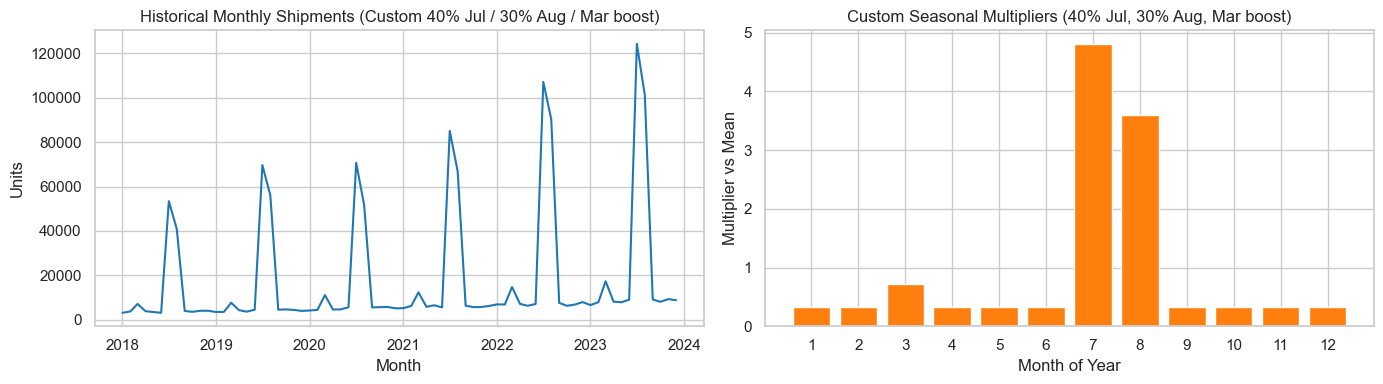

In [7]:
# Regenerate with custom seasonality: 40% Jul, 30% Aug, slight boost in Mar
custom_shares = np.array([
	0.0266667,  # Jan
	0.0266667,  # Feb
	0.06,       # Mar (boosted)
	0.0266667,  # Apr
	0.0266667,  # May
	0.0266667,  # Jun
	0.40,       # Jul
	0.30,       # Aug
	0.0266667,  # Sep
	0.0266667,  # Oct
	0.0266667,  # Nov
	0.0266667,  # Dec
], dtype=float)

# Normalize in case of rounding
custom_shares = custom_shares / custom_shares.sum()

hist_df, seasonal_profile = generate_shipments_series(
	start_date=START_DATE,
	history_years=HISTORY_YEARS,
	base_level=BASE_LEVEL,
	growth_rate=GROWTH_RATE,
	seasonal_amplitude=SEASONAL_AMPLITUDE,
	noise_sd=NOISE_SD,
	custom_monthly_shares=custom_shares,
)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(hist_df["ds"], hist_df["y"], color="tab:blue")
ax[0].set_title("Historical Monthly Shipments (Custom 40% Jul / 30% Aug / Mar boost)")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Units")

ax[1].bar(np.arange(1, 13), custom_shares / custom_shares.mean(), color="tab:orange")
ax[1].set_xticks(range(1, 13))
ax[1].set_title("Custom Seasonal Multipliers (40% Jul, 30% Aug, Mar boost)")
ax[1].set_xlabel("Month of Year")
ax[1].set_ylabel("Multiplier vs Mean")
plt.tight_layout()
plt.show()


11:25:29 - cmdstanpy - INFO - Chain [1] start processing


11:25:29 - cmdstanpy - INFO - Chain [1] done processing


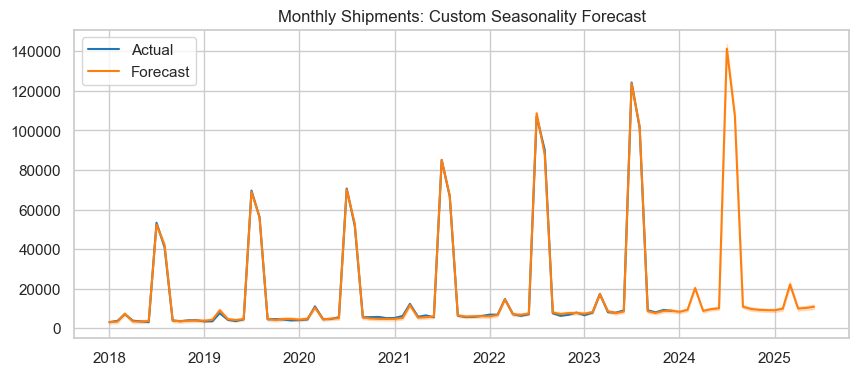

11:25:29 - cmdstanpy - INFO - Chain [1] start processing


11:25:29 - cmdstanpy - INFO - Chain [1] done processing


11:25:29 - cmdstanpy - INFO - Chain [1] start processing


11:25:29 - cmdstanpy - INFO - Chain [1] done processing


11:25:29 - cmdstanpy - INFO - Chain [1] start processing


11:25:30 - cmdstanpy - INFO - Chain [1] done processing


11:25:30 - cmdstanpy - INFO - Chain [1] start processing


11:25:30 - cmdstanpy - INFO - Chain [1] done processing


11:25:30 - cmdstanpy - INFO - Chain [1] start processing


11:25:30 - cmdstanpy - INFO - Chain [1] done processing


11:25:30 - cmdstanpy - INFO - Chain [1] start processing


11:25:30 - cmdstanpy - INFO - Chain [1] done processing


11:25:31 - cmdstanpy - INFO - Chain [1] start processing


11:25:31 - cmdstanpy - INFO - Chain [1] done processing


11:25:31 - cmdstanpy - INFO - Chain [1] start processing


11:25:31 - cmdstanpy - INFO - Chain [1] done processing


,cutoff,MAE_Prophet,RMSE_Prophet,sMAPE_Prophet,MPE_Prophet,MAE_Baseline,RMSE_Baseline,sMAPE_Baseline,MPE_Baseline,FVA_MAE,FVA_RMSE,FVA_sMAPE,FVA_|MPE|
0,2021-01-01,1439.239512,2000.930053,15.142499,-9.515449,3258.897709,6101.194337,17.127144,-15.081815,0.558366,0.672043,0.115877,0.369078
1,2021-04-01,2274.615094,3950.978431,12.906851,11.448158,3270.907657,6113.216502,15.546077,-13.824326,0.304592,0.353699,0.169768,0.171883
2,2021-07-01,1287.449194,2440.372405,7.072333,-2.402460,3897.980382,7788.945684,15.348185,-13.287508,0.669714,0.686688,0.539207,0.819194
3,2021-10-01,1435.842733,2694.251699,7.217370,-1.240863,4696.419354,9389.006353,16.959313,-14.710434,0.694269,0.713042,0.574430,0.915647
4,2022-01-01,1459.038300,2768.848983,6.729683,0.768807,4725.876073,9390.305248,16.907980,-14.017772,0.691266,0.705137,0.601982,0.945155
5,2022-04-01,1427.360398,2693.714086,7.311584,2.639856,4748.434250,9394.453015,16.515074,-13.696744,0.699404,0.713265,0.557278,0.807264
6,2022-07-01,1475.905654,2370.366181,8.430552,3.759416,4485.331193,8511.977959,17.411141,-15.115801,0.670948,0.721526,0.515796,0.751292
7,2022-10-01,2342.759090,4317.270297,8.903797,6.309174,3553.277444,6040.564539,17.104441,-14.893395,0.340677,0.285287,0.479445,0.576378


,MAE_Prophet,MAE_Baseline,FVA_MAE,RMSE_Prophet,RMSE_Baseline,FVA_RMSE,sMAPE_Prophet,sMAPE_Baseline,FVA_sMAPE,MPE_Prophet,MPE_Baseline,FVA_|MPE|
mean,1642.776247,4079.640508,0.578654,2904.591517,7841.207955,0.606336,9.214334,16.614919,0.444223,1.47083,-14.328474,0.669486


In [8]:
# Refit full-history Prophet and rerun backtest on custom seasonality
m_full = Prophet(
	weekly_seasonality=False,
	daily_seasonality=False,
	yearly_seasonality=True,
	seasonality_mode=SEASONALITY_MODE,
)
m_full.fit(hist_df)

future = m_full.make_future_dataframe(periods=FORECAST_HORIZON_MONTHS, freq="MS")
fcst = m_full.predict(future)
forecast_df = fcst[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()

joined = pd.merge(forecast_df, hist_df, on="ds", how="left")
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(joined["ds"], joined["y"], label="Actual", color="tab:blue")
ax.plot(joined["ds"], joined["yhat"], label="Forecast", color="tab:orange")
ax.fill_between(joined["ds"], joined["yhat_lower"], joined["yhat_upper"], color="tab:orange", alpha=0.2)
ax.set_title("Monthly Shipments: Custom Seasonality Forecast")
ax.legend()
plt.show()

backtest_results = rolling_backtest_prophet_vs_baseline(
	hist_df,
	initial_train_years=BACKTEST_INITIAL_YEARS,
	horizon_months=BACKTEST_HORIZON_MONTHS,
	step_months=BACKTEST_STEP_MONTHS,
	seasonality_mode=SEASONALITY_MODE,
)

display(backtest_results)
if not backtest_results.empty:
	cols = [
		"MAE_Prophet","MAE_Baseline","FVA_MAE",
		"RMSE_Prophet","RMSE_Baseline","FVA_RMSE",
		"sMAPE_Prophet","sMAPE_Baseline","FVA_sMAPE",
		"MPE_Prophet","MPE_Baseline","FVA_|MPE|",
	]
	backtest_summary = backtest_results[cols].mean().to_frame("mean").T
	display(backtest_summary)
	backtest_results.to_csv("backtest_results_custom.csv", index=False)
	backtest_summary.to_csv("backtest_summary_custom.csv", index=False)


In [9]:
# Execute rolling backtest and save results
backtest_results = rolling_backtest_prophet_vs_baseline(
	hist_df,
	initial_train_years=BACKTEST_INITIAL_YEARS,
	horizon_months=BACKTEST_HORIZON_MONTHS,
	step_months=BACKTEST_STEP_MONTHS,
	seasonality_mode="multiplicative",
)

display(backtest_results)

if not backtest_results.empty:
	summary_cols = [
		"MAE_Prophet","MAE_Baseline","FVA_MAE",
		"RMSE_Prophet","RMSE_Baseline","FVA_RMSE",
		"sMAPE_Prophet","sMAPE_Baseline","FVA_sMAPE",
		"MPE_Prophet","MPE_Baseline","FVA_|MPE|",
	]
	backtest_summary = backtest_results[summary_cols].mean().to_frame("mean").T
	display(backtest_summary)
	backtest_results.to_csv("backtest_results.csv", index=False)
	backtest_summary.to_csv("backtest_summary.csv", index=False)


11:25:31 - cmdstanpy - INFO - Chain [1] start processing


11:25:31 - cmdstanpy - INFO - Chain [1] done processing


11:25:31 - cmdstanpy - INFO - Chain [1] start processing


11:25:32 - cmdstanpy - INFO - Chain [1] done processing


11:25:32 - cmdstanpy - INFO - Chain [1] start processing


11:25:32 - cmdstanpy - INFO - Chain [1] done processing


11:25:32 - cmdstanpy - INFO - Chain [1] start processing


11:25:32 - cmdstanpy - INFO - Chain [1] done processing


11:25:32 - cmdstanpy - INFO - Chain [1] start processing


11:25:32 - cmdstanpy - INFO - Chain [1] done processing


11:25:32 - cmdstanpy - INFO - Chain [1] start processing


11:25:33 - cmdstanpy - INFO - Chain [1] done processing


11:25:33 - cmdstanpy - INFO - Chain [1] start processing


11:25:33 - cmdstanpy - INFO - Chain [1] done processing


11:25:33 - cmdstanpy - INFO - Chain [1] start processing


11:25:33 - cmdstanpy - INFO - Chain [1] done processing


,cutoff,MAE_Prophet,RMSE_Prophet,sMAPE_Prophet,MPE_Prophet,MAE_Baseline,RMSE_Baseline,sMAPE_Baseline,MPE_Baseline,FVA_MAE,FVA_RMSE,FVA_sMAPE,FVA_|MPE|
0,2021-01-01,1439.239512,2000.930053,15.142499,-9.515449,3258.897709,6101.194337,17.127144,-15.081815,0.558366,0.672043,0.115877,0.369078
1,2021-04-01,2274.615094,3950.978431,12.906851,11.448158,3270.907657,6113.216502,15.546077,-13.824326,0.304592,0.353699,0.169768,0.171883
2,2021-07-01,1287.449194,2440.372405,7.072333,-2.402460,3897.980382,7788.945684,15.348185,-13.287508,0.669714,0.686688,0.539207,0.819194
3,2021-10-01,1435.842733,2694.251699,7.217370,-1.240863,4696.419354,9389.006353,16.959313,-14.710434,0.694269,0.713042,0.574430,0.915647
4,2022-01-01,1459.038300,2768.848983,6.729683,0.768807,4725.876073,9390.305248,16.907980,-14.017772,0.691266,0.705137,0.601982,0.945155
5,2022-04-01,1427.360398,2693.714086,7.311584,2.639856,4748.434250,9394.453015,16.515074,-13.696744,0.699404,0.713265,0.557278,0.807264
6,2022-07-01,1475.905654,2370.366181,8.430552,3.759416,4485.331193,8511.977959,17.411141,-15.115801,0.670948,0.721526,0.515796,0.751292
7,2022-10-01,2342.759090,4317.270297,8.903797,6.309174,3553.277444,6040.564539,17.104441,-14.893395,0.340677,0.285287,0.479445,0.576378


,MAE_Prophet,MAE_Baseline,FVA_MAE,RMSE_Prophet,RMSE_Baseline,FVA_RMSE,sMAPE_Prophet,sMAPE_Baseline,FVA_sMAPE,MPE_Prophet,MPE_Baseline,FVA_|MPE|
mean,1642.776247,4079.640508,0.578654,2904.591517,7841.207955,0.606336,9.214334,16.614919,0.444223,1.47083,-14.328474,0.669486
